# Spectral fitting example

The goal of this notebook is to get familiar with 3ML and get a concrete idea on the spectral fitting will work. 

[3ML](https://threeml.readthedocs.io/) is a high-level interface that allows multiple dataset form different instruments to be used coherently to fit the parameters of source model. A source model typically consists on a list of sources with a parametrized spectral shapes, sky locations and, for extended sources, shape. Polarization is also possible. A "coherent" analysis, in this context, means that the source model parameters are fitted using all available datasets simultanously, rather than performing individual fits and finding a well-suited common model a posteriori. 

In order for a dataset to be included in 3ML, each instrument needs to provide a "plugin". Each plugin is responsible for reading the data, convolving the source model (provided by 3ML) with the instrument response, and returning a likelihood. In our case, we'll compute a binned Poisson likelihood:

$$
\log \mathcal{L}(\mathbf{x}) = \sum_i \log \frac{\lambda_i(\mathbf{x})^{d_i} \exp (-\lambda_i)}{d_i!}
$$

where $d_i$ are the counts on each bin and $\lambda_i$ are the _expected_ counts, given a source model with parameters $\mathbf{x}$. 

In this example, we will fit a single point source with a known location. We'll assume the background is known and fixed. Finally, we will fit a power law:

$$
F(E) = K \left(\frac{E}{E_{piv}}\right)^{-index}
$$


where $K$ (normalization) and the spectral index are the only free parameters, while $E_{piv}$ is the pivot energy which is fixed (and arbitrary).

Considering these assumptions:

$$
\lambda_i(\mathbf{x}) = b_i + s_i(\mathbf{x}) = b_i + s_i(\mathrm{norm}, \mathrm{index})
$$

where $b_i$ are the estimated counts due to background on each bin, and $s_i$ are the corresponding expected counts from the source.

The goal is then to find the values of $\mathbf{x} = [\mathrm{norm}, \mathrm{index}]$ that maximize $\mathcal{L}$. These are the best estimation of the parameters.

The final module needs to also fit the background, handle multiple point-like and extended sources, as well as all the spectral models supported by 3ML. Eventually, it will also fit the polarization angle. However, this simple example already contains all the necessary pieces to do a fit.

## Dependecies

In [1]:
# 3ML stuff
from threeML import PluginPrototype, Model, Powerlaw, PointSource, JointLikelihood, DataList
from astromodels import Parameter

# I'm using gammapy's spectrum for now, but we'll change this to 3ML's.
from gammapy.modeling.models import PowerLawSpectralModel

# We'll yse histpy's Histogram and mhealpy's HealpixMap as the basis
# develop cosipy. These object (or a derivative) will be passed around by 
# the different modules.
from histpy import Histogram, Axis
from mhealpy import HealpixMap

# Needed for coordinate conversion.
# cosipy uses astropy coordinates, with a custom
# SpacecraftFrame (coordinate frame attached to COSI)
from astropy.coordinates import SkyCoord
from cosipy.coordinates import SpacecraftFrame, Attitude

# cosipy uses astropy units
import astropy.units as u
from astropy.time import Time

# Other cosipy modules. Eventually the data classes and 
# SC pos/attitude modules will be needed too.
from cosipy.response import FullDetectorResponse

#Other standard libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy import stats
import collections

22:59:21 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=40435;file:///Users/imartin5/software/astromodels/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=550116;file:///Users/imartin5/software/astromodels/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=503745;file:///Users/imartin5/software/astromodels/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=978411;file:///Users/imartin5/software/astromodels/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

22:59:22 WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=991104;file:///Users/imartin5/software/astromodels/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=494688;file:///Users/imartin5/software/astromodels/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

22:59:22 INFO      Starting 3ML!                                                                     ]8;id=469461;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=811449;file:///Users/imartin5/software/threeML/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=619157;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=572989;file:///Users/imartin5/software/threeML/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=997046;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=106306;file:///Users/imartin5/software/threeML/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=932326;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=694904;file:///Users/imartin5/software/threeML/threeML/__init__.py#40\40]8;;\

22:59:23 WARNING   ROOT minimizer not available                                                ]8;id=954028;file:///Users/imartin5/software/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=231373;file:///Users/imartin5/software/threeML/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=756122;file:///Users/imartin5/software/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=303465;file:///Users/imartin5/software/threeML/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=580486;file:///Users/imartin5/software/threeML/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=727381;file:///Users/imartin5/software/threeML/threeML/minimizer/minimization.py#1369\1369]8;;\

22:59:23 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=943423;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=990345;file:///Users/imartin5/software/threeML/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=45204;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=272256;file:///Users/imartin5/software/threeML/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=478472;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=144205;file:///Users/imartin5/software/threeML/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=668468;file:///Users/imartin5/software/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=213907;file:///Users/imartin5/software/threeML/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=328484;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=299157;file:///Users/imartin5/software/threeML/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=164693;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=187490;file:///Users/imartin5/software/threeML/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=567326;file:///Users/imartin5/software/threeML/threeML/__init__.py\__init__.py]8;;\:]8;id=550323;file:///Users/imartin5/software/threeML/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## 3ML plugin

A 3ML plugin is any class that inherits from 3ML's `PluginPrototype` class. The main two methods that need to be implemented are:
* `set_model`, which translates a 3ML source model into instrument-specific data. In our case, we convolve the source position and spectrum with the COSI response in order to obtain the spected counts from the source.
* `get_log_likelihood`, which return the logarithm of the likelihood (computed with the equation above) that 3ML will combine with the likelihood from other instruments.

In [2]:
class COSILike(PluginPrototype):
    def __init__(self, name, dr, data, bkg, sc_orientation, **kwargs):
        """
        COSI 3ML plugin
        
        Parameters
        ----------
        name : str
            Plugin name e.g. "cosi". Needs to have a distinct name with respect to other plugins in the same analysis
        dr : Path
            Path to full detector response
        data: histpy.Histogram
            Binned data. Note: Eventually this should be a cosipy data class
        bkg: histpy.Histogram
            Binned background model. Note: Eventually this should be a cosipy data class
        sc_orientation: array
            Pair of timestamps (astropy.Time) and attitudes (scoord.Attitude) that describe
            the orientation of the spacecraft for the duration of the data included in
            the analysis. Note: this will eventually be handled by the SC location and
            orientation module
        """
        
        # create the hash for the nuisance parameters. We have none for now.
        nuisance_parameters = collections.OrderedDict()

        # call the prototype constructor. Boilerplate.
        super(COSILike, self).__init__(name, nuisance_parameters)

        # User inputs needed to compute the likelihood
        self._dr = FullDetectorResponse.open(dr)
        self._data = data
        self._bkg = bkg
        self._sc_orientation = sc_orientation
    
        # Place-holder for cached data.
        self._model = None
        self._source = None
        self._psr = None
        self._signal = None
        
    def set_model(self, model):
        """
        Set the model to be used in the joint minimization.
        
        Parameters:
            model: LikelihoodModel
                Any model supported by astromodel. However, this simple plugin only support single 
                point-sources with a power law spectrum
        """
        
        # Check for limitations
        if len(model.extended_sources) != 0 or len(model.particle_sources):
            raise RuntimeError("Only point source models are supported")
        
        sources = model.point_sources
        
        if len(sources) != 1:
            raise RuntimeError("Only one for now")
        
        # Get expectation
        for name,source in sources.items():

            if self._source is None:
                self._source = source
                     
            # Compute point source response for source position
            # See also the Detector Response and Source Injector tutorials
            if self._psr is None:
            
                coord = self._source.position.sky_coord
            
                dwell_time_map = self._get_dwell_time_map(coord)
            
                self._psr = self._dr.get_point_source_response(dwell_time_map)
            
            elif source.position != self._source.position:
                
                raise RuntimeError("No change in position for now")

            # Convolve with spectrum
            # See also the Detector Response and Source Injector tutorials
            spectrum = source.spectrum.main.shape
            
            # Here we translate to gammapy. We will make the detector response
            # accept 3ML models and there will be no need for this
            if not isinstance(spectrum, Powerlaw):
                raise RuntimeError("Only PowerLaw supported for now")

            spectrum = PowerLawSpectralModel(
                            index = -spectrum.index.value,
                            amplitude = spectrum.K.value * spectrum.K.unit,
                            reference = spectrum.piv.value * spectrum.piv.unit)
                
            self._signal = self._psr.get_expectation(spectrum).project(['Em', 'Phi', 'PsiChi'])
            
        # Cache
        self._model = model

    def get_log_like(self):

        # Recompute the expectation if any parameter in the model changed
        if self._model is None:
            log.error("You need to set the model first")
        
        self.set_model(self._model)
        
        # Compute "lambda" in the equations above
        expectation = self._signal.contents + self._bkg.contents
        
        data = self._data.contents # Into an array
        
        # Compute the log-likelihood from the equations above
        log_like = np.sum(np.log(np.power(expectation, data) * 
                             np.exp(-expectation) / 
                             factorial(data)))
        
        return log_like

    def inner_fit(self):
        """
        This fits nuisance parameters, but we have none for now.
        """
        
        return self.get_log_like()
    
    def _get_dwell_time_map(self, coord):
        """
        This will be eventually be provided by another module
        """
        
        # The dwell time map has the same pixelation (base) as the detector response.
        # We start with an empty map
        dwell_time_map = HealpixMap(base = self._dr, 
                                    unit = u.s, 
                                    coordsys = SpacecraftFrame())

        # Get timestamps and attitude values
        timestamps, attitudes = zip(*self._sc_orientation)
            
        for attitude,duration in zip(attitudes[:-1], np.diff(timestamps)):

            local_coord = coord.transform_to(SpacecraftFrame(attitude = attitude))

            # Here we add duration in between timestamps using interpolations
            pixels, weights = dwell_time_map.get_interp_weights(local_coord)

            for p,w in zip(pixels, weights):
                dwell_time_map[p] += w*duration.to(u.s)
        
        return dwell_time_map

## 3ML fitting

Fitting in 3ML begins by instantiating all plugins. Each one needs different inputs, specific to each instrument. Although 3ML was designed to fit data from multiple instruments, we can also fit data from a single detector without any changes to the workflow. For now, "cosi" is our only plugin:

In [3]:
# Inputs needed by the COSI plugin
# We'll use fake data from the "Source injector" tutorial
dr = "/Users/imartin5/cosi/scratch/rsp/compton_sphere/FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5"
data = Histogram.open("data.h5")
bkg = Histogram.open("bkg.h5")
signal = Histogram.open("signal.h5")

# 1s duration. Spacecraft aligned with the ICRS ([0,0,0,1] = Identity)
sc_orientation = [(Time('2025-01-01T13:02:01.00'), Attitude.from_quat([0,0,0,1])), 
                  (Time('2025-01-01T13:02:02.00'), Attitude.from_quat([0,0,0,1]))]

# Instantiate the plugin
# Note that we'll use 3x the signal we injected before. 
cosi = COSILike("cosi",
                dr = dr,
                data = bkg + 3*signal, 
                bkg = bkg, 
                sc_orientation = sc_orientation)

# Corresponding parameters, for reference
norm_inj = 3e-1 # 1/keV/cm2/s (3x the injected signal)
piv_inj = 1 # keV
index_inj = -1.7 

The next step is to initialize the model that contains all free parameters:

In [4]:
# Our model will contain a single source with a power law spectrum
spectrum = Powerlaw()

# Setting the parameter to something reasonable helps the 
# fitting to converge
spectrum.piv.value = 1 # keV
spectrum.K.value = 1 # 1/keV/cm2/s
spectrum.index.value = -2

# Optional: change pivot energy
# The pivot value is arbitrary, ideally nothing should depend on it
# However, it is recommended to choose a value near the energy
# for which the detector is most sensitive ir onder to minimize
# the correlation between the normalization and spectral index.
# Try setting it to 500 keV and see how the results change
# piv =  500 #keV
# spectrum.K.value = spectrum(piv) # 1/keV/cm2/s
# spectrum.piv.value = piv # keV

# Point source instance, at the know location (from the "Source Injectior" tutorial)
source = PointSource("source", # The name of the source is arbitrary, but needs to be unique
                     ra = 20, #deg 
                     dec = 40, #deg
                     spectral_shape = spectrum)

# Adding the source to the model
# If we had multiple sources, we would do Model(source1, source2, ...)
model = Model(source)

# Optional: if you want to call get_log_like manually, then you
# also need to set the model manually. 3ML does this internanlly during the fit though
cosi.set_model(model)

And finally, let 3ML maximize the likelihood:

In [5]:
# Gather all plugins. 
# If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)
plugins = DataList(cosi)

# Put model and pluging together
like = JointLikelihood(model, plugins, verbose = False)

# Maximum likelihood
like.fit()

22:59:26 INFO      set the minimizer to minuit                                             ]8;id=779421;file:///Users/imartin5/software/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=616175;file:///Users/imartin5/software/threeML/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

22:59:40 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=499208;file:///Users/imartin5/software/threeML/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=378081;file:///Users/imartin5/software/threeML/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Powerlaw.K,(3.0 -1.8 +5) x 10^-1,1 / (cm2 keV s)
source.spectrum.main.Powerlaw.index,-1.70 +/- 0.15,


Correlation matrix:

1.00,-0.99
-0.99,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,4540.459283
total,4540.459283


Values of statistical measures:

,statistical measures
AIC,9078.918566
BIC,9080.918566


(                                        value  negative_error  positive_error  \
 source.spectrum.main.Powerlaw.K      0.300053       -0.180704        0.453719   
 source.spectrum.main.Powerlaw.index -1.700008       -0.146019        0.147397   
 
                                         error             unit  
 source.spectrum.main.Powerlaw.K      0.317212  1 / (cm2 keV s)  
 source.spectrum.main.Powerlaw.index  0.146708                   ,
        -log(likelihood)
 cosi        4540.459283
 total       4540.459283)

Compare this with the values used for the injection.

## 3ML error propagation and plotting

The summary of the results above tell you the optimal values of `K` and `index`, as well as the errors. You typically want to propagate these into the error in the flux at different energies, and plot the spectrum. Let's do that:

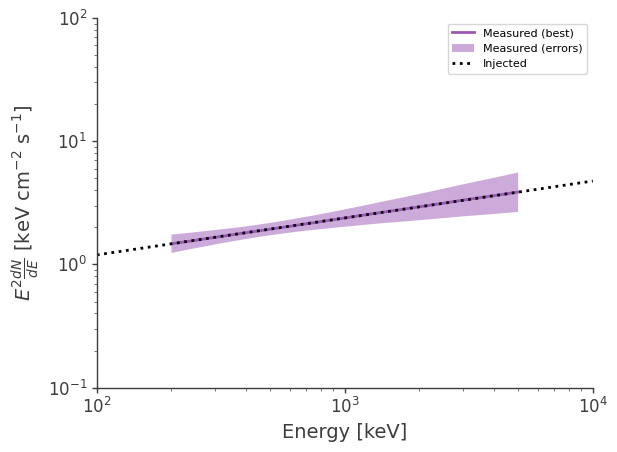

In [6]:
# Propagate the errors to the "evaluate_at" method of the spectrum
results = like.results

parameters = {par.name:results.get_variates(par.path)
              for par in results.optimized_model["source"].parameters.values()
              if par.free}

results_err = results.propagate(results.optimized_model["source"].spectrum.main.shape.evaluate_at, **parameters)

# Evaluate at multiple energy values, for plotting
energy = np.geomspace(200*u.keV,5*u.MeV).to_value(u.keV)

flux_lo = np.zeros_like(energy)
flux_median = np.zeros_like(energy)
flux_hi = np.zeros_like(energy)

for i, e in enumerate(energy):
    
    flux = results_err(e)

    flux_median[i] = flux.median
    flux_lo[i], flux_hi[i] = flux.equal_tail_interval(cl=0.68)

    
# Plot
fig,ax = plt.subplots()

ax.plot(energy, energy*energy*flux_median, label = "Measured (best)")

ax.fill_between(energy, energy*energy*flux_lo, energy*energy*flux_hi, alpha = .5, label = "Measured (errors)")

energy_inj = np.geomspace(1e2, 1e4)
ax.plot(energy_inj, energy_inj*energy_inj*norm_inj*(energy_inj/piv_inj)**index_inj, color = 'black', ls = ":", label = "Injected")

ax.set_xscale("log")

ax.set_yscale("log")

ax.set_xlim(1e2, 1e4)
ax.set_ylim(1e-1, 100)

ax.set_xlabel("Energy [keV]")
ax.set_ylabel(r"$E^2 \frac{dN}{dE}$ [keV cm$^{-2}$ s$^{-1}$]")

ax.legend();

## TS grid (brute force fitting)

The function `fit()` above is simply finding the maximum value of `cosi.get_log_like()`, and then using the difference in likelihood as a function of each parameter to find the errors and correlations. It can be enlightening to see this visually, so let's see how the likelihood profile looks by evaluating it at multiple location in grid. This might take a few minutes, it's a _brute_ force method after all.

In [7]:
# Find a reasonable range to evaluate, based on the 99% confidence intervals
index_range = results.get_equal_tailed_interval('source.spectrum.main.Powerlaw.index', cl = .99)
norm_range = results.get_equal_tailed_interval('source.spectrum.main.Powerlaw.K', cl = .99)

log_like = Histogram([Axis(np.linspace(*index_range, 30), label = "index"), 
                      Axis(np.linspace(*norm_range, 31), label = "norm")])

for i in range(log_like.axes['index'].nbins):
    for j in range(log_like.axes['norm'].nbins):
        
        # Progress
        print(f"\ri = {i:2d}/{log_like.axes['index'].nbins}  j = {j:2d}/{log_like.axes['norm'].nbins}", end = "")
        
        # Change the spectrum parameters
        spectrum.K.value = log_like.axes['norm'].centers[j]
        spectrum.index.value = log_like.axes['index'].centers[i]

        # Recompute the likelihood
        log_like[i,j] = cosi.get_log_like()

i = 28/29  j = 29/30

The log likelihood can also be used in hypothesis testing. Given the likelihood for a null-hypothesis model $\mathcal{L}_0$, Wilks' theorem says that, when the sample size approaches infinity, the test statistic

$$
TS = 2 \frac{\mathrm{max} \mathcal{L}}{\mathrm{max} \mathcal{L}_0}
$$

approaches a $\chi^2$ distribution under the null-hypothesis. The number of degrees of freedom equals to the difference in the number of parameters between the alternative and the null hypothesis (all parameter of the null hypothesis must be present in the alternative hypothesis, aka _nested models_). Although this only applies for large sample size, it is usually a good first approximation. 

To make this more concrete, a common null hypothesis is that there is no source, only background, and the alternative hypothesis is that there is a source. In our example, the alternative model has 2 degrees of freedom (normalization and index), and the null-hypothesis had none (because we assummed the background is known and fixed).

Since the $\mathcal{L}_0$ is just a constant, we can compute it directly once and for all:

In [8]:
# Set the normalization to 0, that is, background-only null-hypothesis
spectrum.K.value = spectrum.K.min_value # min_value is a very small value, approx 0. However, it can't be exactly 0 for some internal numerical reason

# Compute the likelihood
log_like0 = cosi.get_log_like()

The TS is then

In [9]:
ts = 2*(log_like - log_like0)

# Getting the maximum
# Note that, in our case, since log_like0 is a constant,
# max(TS) = 2
argmax = np.unravel_index(np.argmax(ts), ts.nbins)

ts_max = ts[argmax]

# And converting to significance based on Wilk's theorem
print(f"Expected significance: {stats.norm.isf(stats.chi2.sf(ts_max, df = 2)):.1f} sigma")

Expected significance: 10.4 sigma


Finally, let's plot the TS profile vs the free parameters, find the maximumum and use Wilk's theorem to estimate a confidence interval. 

Note that since `log_like0` does not depend on the source parameters, TS looks the same as `log_like`, up to a constant and a factor of 2.

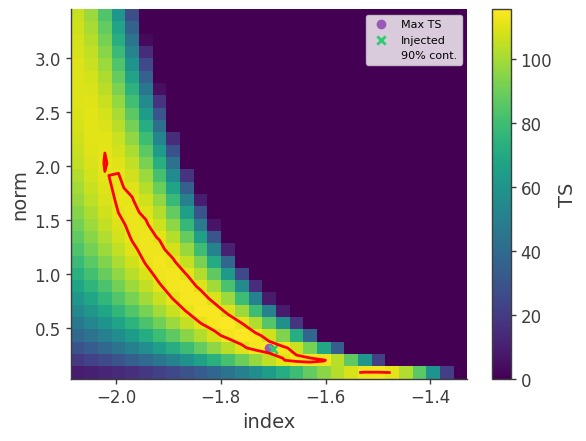

In [19]:
fig,ax = plt.subplots()

_,plot = ts.plot(ax, vmin = 0, colorbar = False)

ax.scatter([ts.axes['index'].centers[argmax[0]]],[ts.axes['norm'].centers[argmax[1]]], label = "Max TS")

ax.scatter([index_inj],[norm_inj*(spectrum.piv.value/piv_inj)**index_inj], marker = "x", label = "Injected")

# Here we also use Wilk's theorem to find the DeltaTS that corresponse to a 90% containment confidence
ts_thresh = ts_max - stats.chi2.isf(1-.9, df = 2)
contours = ax.contour(ts.axes['index'].centers, 
                      ts.axes['norm'].centers, 
                      ts.contents.transpose(), 
                      [ts_thresh], colors = 'red')
contours.collections[0].set_label("90% cont.")

cbar = fig.colorbar(plot)
cbar.ax.set_ylabel("TS")

ax.legend();

The "banana" shape, and the high correlation between the normalization and index, is due to the pivot energy value being far from optimal. Try running this notebook again with value closer to COSI's "sweet spot".